In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.dates as mdates
from matplotlib import ticker
import emd
from scipy import ndimage
import pandas as pd
import datetime

### Load Data

In [2]:
Buoy = 'E06'
springtime = xr.open_dataset("LiDAR/springtime_"+Buoy+".nc")
jet_id = xr.open_dataset('LiDAR/springtime_'+Buoy+'_LLJs_2020.nc')

SGP_lidar = xr.open_dataset('LiDAR/SGP_lidar.nc').sel(site='C1')
SGP_jets = xr.open_dataset('LiDAR/SGP_jet_id.nc')

SGP_jets['datetime'] = SGP_lidar['time']
SGP_jets = SGP_jets.rename(dict({'Time':'time'}))
SGP_lidar['datetime'] = SGP_lidar['time']
SGP_lidar = SGP_lidar.rename(dict({'height': 'z'}))
SGP_lidar['height'] = SGP_lidar['z']
SGP_lidar['U'] = SGP_lidar['u']
SGP_lidar['V'] = SGP_lidar['v']

In [3]:
SGP_lidar['z'].isel(z=23)

<xarray.DataArray 'z' ()>
array(688.49023, dtype=float32)
Coordinates:
    z        float32 688.5
    site     <U2 'C1'
Attributes:
    long_name:      Height above ground level
    units:          m
    standard_name:  height

In [4]:
lat = SGP_lidar['lat']
f = 2*7.2921e-5 * np.sin(lat/180 * np.pi) # coriolis term
print(2*np.pi / f / 3600)

<xarray.DataArray 'lat' ()>
array(20.06922701)
Coordinates:
    site     <U2 'C1'


In [5]:
springtime['height']

<xarray.DataArray 'height' (z: 10)>
array([ 18,  38,  58,  78,  98, 118, 138, 158, 178, 198])
Coordinates:
    height   (z) int64 18 38 58 78 98 118 138 158 178 198
Dimensions without coordinates: z

In [6]:
cases = dict({
    'E05': dict({
        'allSpring': [0, -1],
        '20200403': [288, 1152],     # 2020-04-03 to 2020-04-09
        '20200513': [6048, 6912],   # 2020-05-13 to 2020-05-19
        '20200602': [8928, 9792],   # 2020-06-02 to 2020-06-08
    }),
    'E06': dict({        
        'allSpring': [0, -1],
        '20200403': [288, 1152],    # 2020-04-03 to 2020-04-09
        '20200513': [5467, 6331],
        '20200602': [8347, 9211],
    })
})

### Plot frequency spectra

In [7]:
from emd.support import EMDSiftCovergeError
from numpy.linalg import LinAlgError

def nan_helper(y):
    return np.isnan(y.data), lambda z: z.nonzero()[0]

def plot_frequency_spectra(data, ax, var):
    nans, x = nan_helper(data[var])
    data[var].data[nans] = np.interp(x(nans), x(~nans), data[var].data[~nans])

    imf = emd.sift.mask_sift(data[var].data)
    IP, IF, IA = emd.spectra.frequency_transform(imf, 1/600, 'nht')

    freq_edges, freq_centres = emd.spectra.define_hist_bins(1e-6, 1e-3, 100, 'log')
    f, spec_weighted = emd.spectra.hilberthuang(IF, IA, freq_edges, sum_imfs=False)

    spec_weighted[np.isnan(spec_weighted)] = 0.0
    sum_weights = np.sum(spec_weighted)

    for imf in range(len(spec_weighted[0])):
        imax = np.argmax(spec_weighted[:,imf]/sum_weights)
        T = np.int16(np.round(1/f[imax]/3600, 0))
        if spec_weighted[imax, imf]/sum_weights > 0.02:
            ax.annotate(str(T) + "h", (f[imax]*0.9,spec_weighted[imax,imf]/sum_weights + 0.002))

    ax.set_ylim([0.0, np.max(spec_weighted / sum_weights) * 1.1])

    ax.step(freq_centres, spec_weighted/sum_weights)
    ax.set_xscale('log')

In [8]:
def get_frequency_ranges(type):
    if type=="20200602":
        f_sec_edges = dict({'60h': [1e-6, 7e-6], '28h': [7e-6, 1.4e-5], '14h': [1.4e-5, 2.4e-5], '8h': [2.4e-5, 5e-5]})
    elif type=="20200513":
        f_sec_edges = dict({'60h': [1e-6, 7e-6], '28h': [7e-6, 1.4e-5], '14h': [1.4e-5, 2.4e-5], '8h': [2.4e-5, 5e-5]})
    elif type=="20200403":
       f_sec_edges = dict({'60h': [1e-6, 7e-6], '28h': [7e-6, 1.4e-5], '14h': [1.4e-5, 2.4e-5], '8h': [2.4e-5, 5e-5]})
    elif type=="SGP":
       f_sec_edges = dict({'60h': [1e-6, 7e-6], '28h': [7e-6, 1.2e-5], '19h': [1.2e-5, 2.4e-5], '8h': [2.4e-5, 5e-5]})
    else:
        f_sec_edges = dict({'60h': [1e-6, 7e-6], '28h': [7e-6, 1.4e-5], '14h': [1.4e-5, 2.4e-5], '8h': [2.4e-5, 5e-5]})
    
    return f_sec_edges

 Inputs samples (864) is small for specified max_imfs (9) very likely that 8 or fewer imfs are returned
 Inputs samples (864) is small for specified max_imfs (9) very likely that 8 or fewer imfs are returned
 Inputs samples (864) is small for specified max_imfs (9) very likely that 8 or fewer imfs are returned
 Inputs samples (864) is small for specified max_imfs (9) very likely that 8 or fewer imfs are returned
 Inputs samples (864) is small for specified max_imfs (9) very likely that 8 or fewer imfs are returned
 Inputs samples (864) is small for specified max_imfs (9) very likely that 8 or fewer imfs are returned


TypeError: 'NoneType' object is not iterable

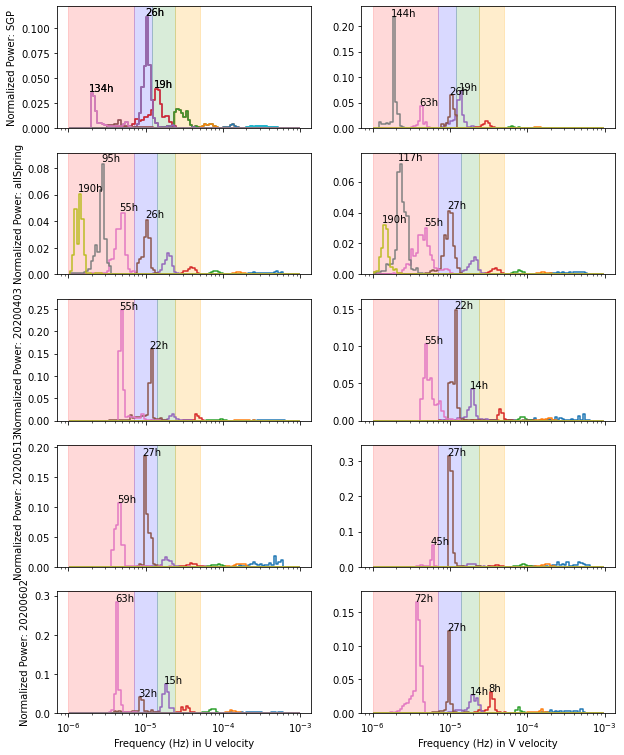

In [10]:
(fig, ax) = plt.subplots(nrows=5, ncols=2, sharex=True, figsize=(10,13))

# SGP
z_sel = 12
for (j, var) in enumerate(['u','v']):
    if j==0:
        plot_frequency_spectra(SGP_lidar.isel(z=z_sel),ax[0][j],var)
    ranges = get_frequency_ranges('SGP')
    box1 = ax[0][j].axvspan(ranges['60h'][0], ranges['60h'][1], alpha=0.15, label='type 1', color='red')
    box2 = ax[0][j].axvspan(ranges['28h'][0], ranges['28h'][1], alpha=0.15, label='type 2', color='blue')
    box3 = ax[0][j].axvspan(ranges['19h'][0], ranges['19h'][1], alpha=0.15, label='type 3', color='green')
    box4 = ax[0][j].axvspan(ranges['8h'][0], ranges['8h'][1], alpha=0.2, label='type 4', color='orange')
    plot_frequency_spectra(SGP_lidar.isel(z=z_sel),ax[0][j],var)
ax[0,0].set_ylabel('Normalized Power: SGP')

# NYSERDA
z_sel = 7
for (ii,event) in enumerate(cases[Buoy]):
    i = ii + 1
    subset = springtime.isel(t=slice(cases[Buoy][event][0], cases[Buoy][event][1]), z=z_sel)
    for (j, var) in enumerate(['U', 'V']):
        ranges = get_frequency_ranges(event)
        ax[i][j].axvspan(ranges['60h'][0], ranges['60h'][1], alpha=0.15, label='type 1', color='red')
        ax[i][j].axvspan(ranges['28h'][0], ranges['28h'][1], alpha=0.15, label='type 2', color='blue')
        ax[i][j].axvspan(ranges['14h'][0], ranges['14h'][1], alpha=0.15, label='type 3', color='green')
        ax[i][j].axvspan(ranges['8h'][0], ranges['8h'][1], alpha=0.2, label='type 4', color='orange')
        plot_frequency_spectra(subset, ax[i][j], var)
    ax[i,0].set_ylabel('Normalized Power: ' + event)


ax[-1,0].set_xlabel('Frequency (Hz) in U velocity')
ax[-1,1].set_xlabel('Frequency (Hz) in V velocity')
ax[0,0].legend(['IMF-1', 'IMF-2', 'IMF-3', 'IMF-4', 'IMF-5', 'IMF-6', 'IMF-7','IMF-8','IMF-9'], frameon=False)
ax[0,1].legend([box1, box2, box3, box4], ['type 1','type 2', 'type 3','type 4'], frameon=False)

plt.tight_layout()

plt.savefig('figures/fig7_frequency_spectra_E06_shaded.pdf')

### Plot time-height for frequency ranges

In [18]:
def plot_frequency_timeheight(event, data, axU, axV, max_h_lvl, freq_ind, jet_data, set_title=None, xlim=None, cmax=7):
    (t,z) = np.meshgrid(data['datetime'], data['height'].isel(z=slice(0,max_h_lvl)))
    clevels = np.linspace(0.0, cmax, cmax+1)
    hht_io_tz_amplitude = np.zeros((max_h_lvl, len(data['datetime']), 2))
    f_sec_edges = get_frequency_ranges(event)
    freq_edges = f_sec_edges[list(f_sec_edges.keys())[freq_ind]]
    
    for (ivar, var) in enumerate(['U','V']):
        nans, x = nan_helper(data[var])
        data[var].data[nans] = np.interp(x(nans), x(~nans), data[var].data[~nans])

        for h_level_select in range(0,max_h_lvl):
            imf = emd.sift.mask_sift(data[var].isel(z = h_level_select).data)
            IP, IF, IA = emd.spectra.frequency_transform(imf, 1/600, 'hilbert')
            # then filter the IF and plot the IA instantaneously
            IF1 = np.where(IF > freq_edges[0], IF, np.zeros_like(IF))
            IF2 = np.where(IF1 < freq_edges[1], IF1, np.zeros_like(IF))
            IA_IO = np.where(IF2 > 0.0, IA, np.zeros_like(IF))
            hht_io_tz_amplitude[h_level_select,:,ivar] = np.sum(IA_IO, axis=1)

    CS1 = axU.contourf(t.T,z.T,hht_io_tz_amplitude[:,:,0].T, clevels, extend='max')
    axU.scatter(data['datetime'], jet_data['jet_nose_height'],c='k',s=4)
    axU.set_ylim([data['height'][0], data['height'][max_h_lvl-1]])

    CS2 = axV.contourf(t.T,z.T,hht_io_tz_amplitude[:,:,1].T, clevels, extend='max')
    axV.scatter(data['datetime'], jet_data['jet_nose_height'],c='k',s=4)
    axV.set_ylim([data['height'][0], data['height'][max_h_lvl-1]])
    axU.set_ylabel('z (m)')
    axV.set_ylabel('z (m)')
    if xlim is not None:
        axU.set_xlim([xlim[0], xlim[1]])
        axV.set_xlim([xlim[0], xlim[1]])
    axU.xaxis.set_major_formatter(mdates.ConciseDateFormatter(axU.xaxis.get_major_locator(), offset_formats=['', '%Y', '%Y-%B', '%Y-%B-%d', '%Y-%B-%d', '%Y-%B-%d %H:%M']))
    axV.xaxis.set_major_formatter(mdates.ConciseDateFormatter(axV.xaxis.get_major_locator(), offset_formats=['', '%Y', '%Y-%B', '%Y-%B-%d', '%Y-%B-%d', '%Y-%B-%d %H:%M']))

    fig.colorbar(CS1, ax=axU)
    fig.colorbar(CS2, ax=axV)

    if set_title is not None:
        axU.set_title(set_title + ' $U$ (m s$^{-1}$)')
        axV.set_title(set_title + ' $V$ (m s$^{-1}$)')

In [19]:
def plot_data_timeheight(event, data, axU, axV, max_h_lvl, jet_data, set_title=None, xlim=None, cmin=-15, cmax=15):
    (t,z) = np.meshgrid(data['datetime'], data['height'].isel(z=slice(0,max_h_lvl)))
    clevels = np.linspace(cmin, cmax, cmax-cmin+1)
    
    for (ivar, var) in enumerate(['U','V']):
        nans, x = nan_helper(data[var])
        data[var].data[nans] = np.interp(x(nans), x(~nans), data[var].data[~nans])

    CS1 = axU.contourf(t.T,z.T,data['U'].isel(z=slice(0,max_h_lvl)), clevels, extend='both', cmap='hot')
    axU.scatter(data['datetime'], jet_data['jet_nose_height'],c='k',s=4)
    axU.set_ylim([data['height'][0], data['height'][max_h_lvl-1]])

    CS2 = axV.contourf(t.T,z.T,data['V'].isel(z=slice(0,max_h_lvl)), clevels, extend='both', cmap='hot')
    axV.scatter(data['datetime'], jet_data['jet_nose_height'],c='k',s=4)
    axV.set_ylim([data['height'][0], data['height'][max_h_lvl-1]])
    axU.set_ylabel('z (m)')
    axV.set_ylabel('z (m)')
    if xlim is not None:
        axU.set_xlim([xlim[0], xlim[1]])
        axV.set_xlim([xlim[0], xlim[1]])
    axU.xaxis.set_major_formatter(mdates.ConciseDateFormatter(axU.xaxis.get_major_locator(), offset_formats=['', '%Y', '%Y-%B', '%Y-%B-%d', '%Y-%B-%d', '%Y-%B-%d %H:%M']))
    axV.xaxis.set_major_formatter(mdates.ConciseDateFormatter(axV.xaxis.get_major_locator(), offset_formats=['', '%Y', '%Y-%B', '%Y-%B-%d', '%Y-%B-%d', '%Y-%B-%d %H:%M']))

    fig.colorbar(CS1, ax=axU)
    fig.colorbar(CS2, ax=axV)

    if set_title is not None:
        axU.set_title(set_title + ' $U$ (m s$^{-1}$)')
        axV.set_title(set_title + ' $V$ (m s$^{-1}$)')

 Inputs samples (864) is small for specified max_imfs (9) very likely that 8 or fewer imfs are returned
 Inputs samples (864) is small for specified max_imfs (9) very likely that 8 or fewer imfs are returned
 Inputs samples (864) is small for specified max_imfs (9) very likely that 8 or fewer imfs are returned
 Inputs samples (864) is small for specified max_imfs (9) very likely that 8 or fewer imfs are returned
 Inputs samples (864) is small for specified max_imfs (9) very likely that 8 or fewer imfs are returned
 Inputs samples (864) is small for specified max_imfs (9) very likely that 8 or fewer imfs are returned
 Inputs samples (864) is small for specified max_imfs (9) very likely that 8 or fewer imfs are returned
 Inputs samples (864) is small for specified max_imfs (9) very likely that 8 or fewer imfs are returned
 Inputs samples (864) is small for specified max_imfs (9) very likely that 8 or fewer imfs are returned
 Inputs samples (864) is small for specified max_imfs (9) very l

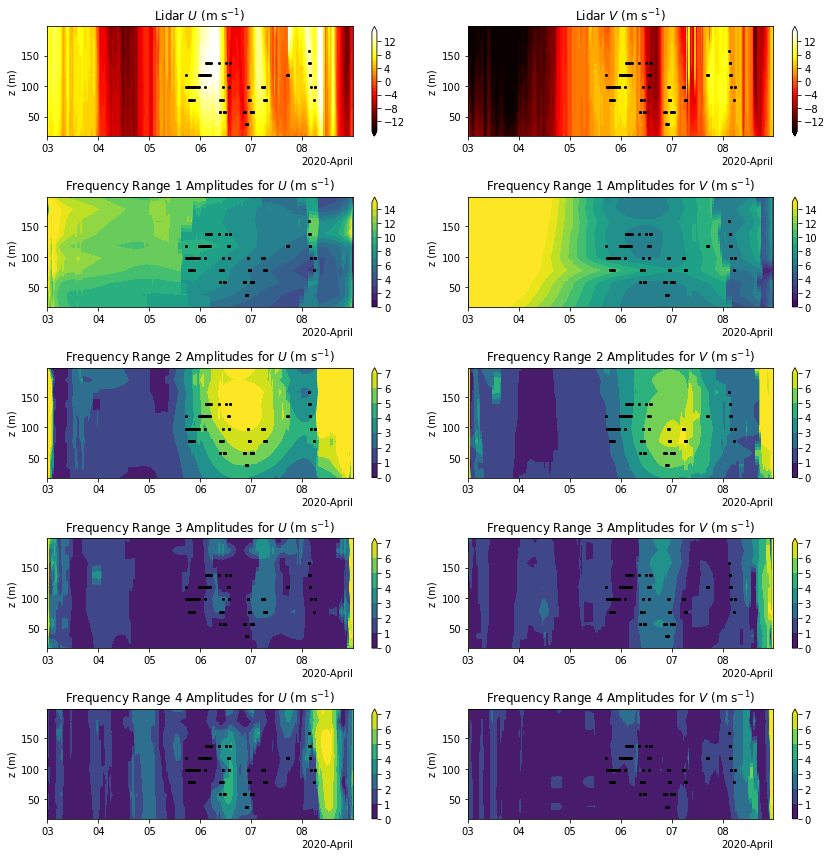

In [20]:
(fig, ax) = plt.subplots(nrows=5, ncols=2, figsize=(12,12))

event = '20200403'
data = springtime.isel(t=slice(cases[Buoy][event][0], cases[Buoy][event][1]))
jet_data = jet_id.isel(t=slice(cases[Buoy][event][0], cases[Buoy][event][1]))

plot_data_timeheight(event, data, ax[0][0], ax[0][1], 10, jet_data, set_title='Lidar')

for i in range(4):
    plot_frequency_timeheight(event, data, ax[i+1][0], ax[i+1][1], 10, i, jet_data, cmax=(15 if i==0 else 7), set_title='Frequency Range ' + str(i+1) + ' Amplitudes for')

plt.tight_layout()

plt.savefig('figures/fig9_frequency_timeheight_'+event+'.pdf')

 Inputs samples (864) is small for specified max_imfs (9) very likely that 8 or fewer imfs are returned
 Inputs samples (864) is small for specified max_imfs (9) very likely that 8 or fewer imfs are returned
 Inputs samples (864) is small for specified max_imfs (9) very likely that 8 or fewer imfs are returned
 Inputs samples (864) is small for specified max_imfs (9) very likely that 8 or fewer imfs are returned
 Inputs samples (864) is small for specified max_imfs (9) very likely that 8 or fewer imfs are returned
 Inputs samples (864) is small for specified max_imfs (9) very likely that 8 or fewer imfs are returned
 Inputs samples (864) is small for specified max_imfs (9) very likely that 8 or fewer imfs are returned
 Inputs samples (864) is small for specified max_imfs (9) very likely that 8 or fewer imfs are returned
 Inputs samples (864) is small for specified max_imfs (9) very likely that 8 or fewer imfs are returned
 Inputs samples (864) is small for specified max_imfs (9) very l

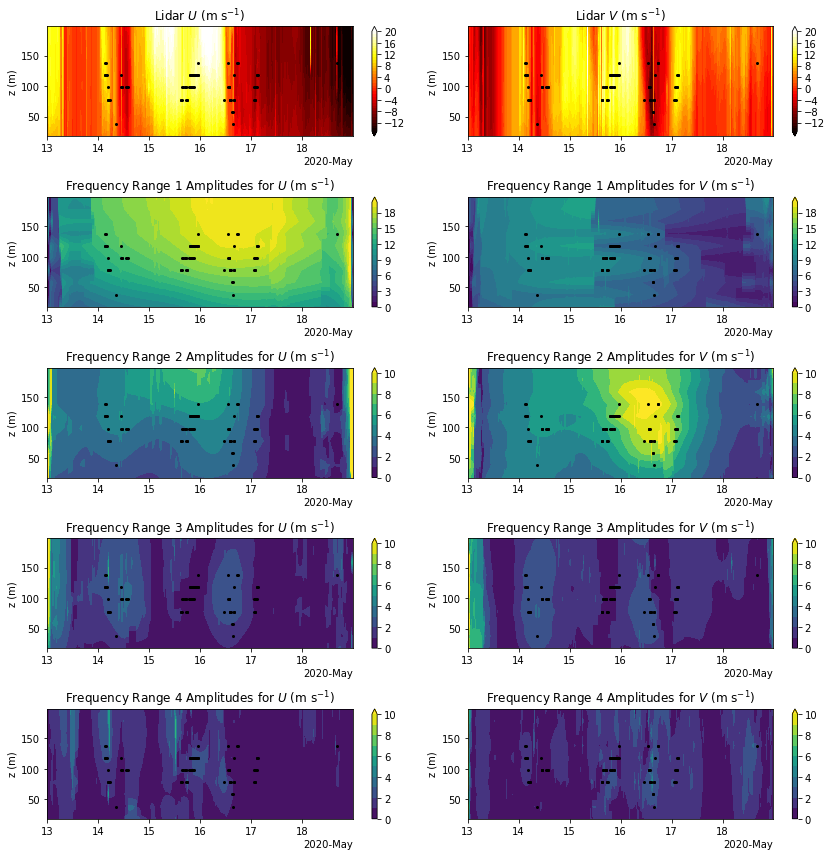

In [21]:
(fig, ax) = plt.subplots(nrows=5, ncols=2, figsize=(12,12))

event = '20200513'
data = springtime.isel(t=slice(cases[Buoy][event][0], cases[Buoy][event][1]))
jet_data = jet_id.isel(t=slice(cases[Buoy][event][0], cases[Buoy][event][1]))

plot_data_timeheight(event, data, ax[0][0], ax[0][1], 10, jet_data, set_title='Lidar', cmin=-15, cmax=20)

for i in range(4):
    plot_frequency_timeheight(event, data, ax[i+1][0], ax[i+1][1], 10, i, jet_data, cmax=(20 if i==0 else 10), set_title='Frequency Range ' + str(i+1) + ' Amplitudes for')

plt.tight_layout()

plt.savefig('figures/fig10_frequency_timeheight_'+event+'.pdf')

 Inputs samples (864) is small for specified max_imfs (9) very likely that 8 or fewer imfs are returned
 Inputs samples (864) is small for specified max_imfs (9) very likely that 8 or fewer imfs are returned
 Inputs samples (864) is small for specified max_imfs (9) very likely that 8 or fewer imfs are returned
 Inputs samples (864) is small for specified max_imfs (9) very likely that 8 or fewer imfs are returned
 Inputs samples (864) is small for specified max_imfs (9) very likely that 8 or fewer imfs are returned
 Inputs samples (864) is small for specified max_imfs (9) very likely that 8 or fewer imfs are returned
 Inputs samples (864) is small for specified max_imfs (9) very likely that 8 or fewer imfs are returned
 Inputs samples (864) is small for specified max_imfs (9) very likely that 8 or fewer imfs are returned
 Inputs samples (864) is small for specified max_imfs (9) very likely that 8 or fewer imfs are returned
 Inputs samples (864) is small for specified max_imfs (9) very l

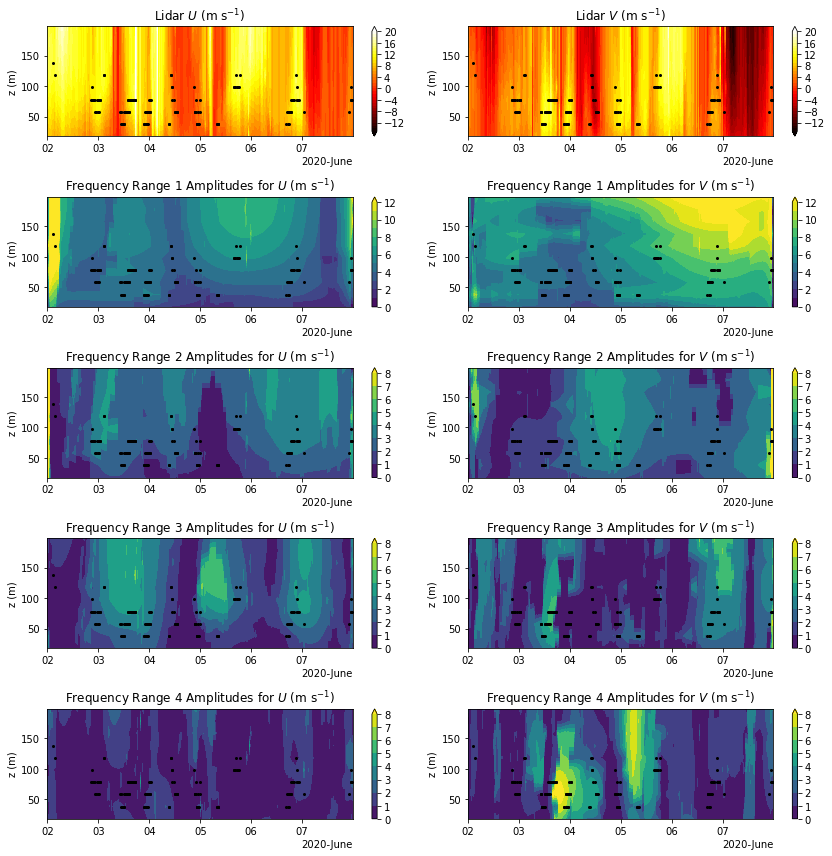

In [22]:
(fig, ax) = plt.subplots(nrows=5, ncols=2, figsize=(12,12))

event = '20200602'
data = springtime.isel(t=slice(cases[Buoy][event][0], cases[Buoy][event][1]))
jet_data = jet_id.isel(t=slice(cases[Buoy][event][0], cases[Buoy][event][1]))

plot_data_timeheight(event, data, ax[0][0], ax[0][1], 10, jet_data, set_title='Lidar', cmin=-15, cmax=20)

for i in range(4):
    plot_frequency_timeheight(event, data, ax[i+1][0], ax[i+1][1], 10, i, jet_data, cmax=(12 if i==0 else 8), set_title='Frequency Range ' + str(i+1) + ' Amplitudes for')

plt.tight_layout()

plt.savefig('figures/fig11_frequency_timeheight_'+event+'.pdf')

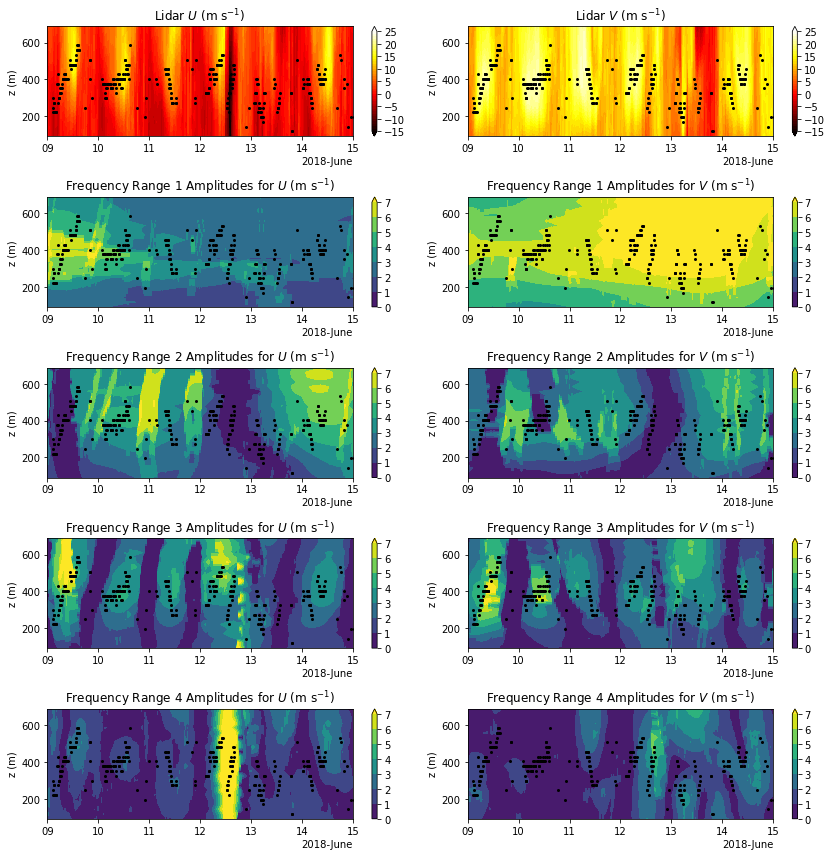

In [23]:
(fig, ax) = plt.subplots(nrows=5, ncols=2, figsize=(12,12))

event = 'SGP'
data = SGP_lidar
jet_data = SGP_jets

plot_data_timeheight(event, data, ax[0][0], ax[0][1], 24, jet_data, set_title='Lidar', cmin=-15, cmax=25, xlim=[np.datetime64('2018-06-09T00:00:00'), np.datetime64('2018-06-15T00:00:00')])

for i in range(4):
    plot_frequency_timeheight(event, data, ax[i+1][0], ax[i+1][1], 24, i, jet_data, cmax=(7 if i==0 else 7), set_title='Frequency Range ' + str(i+1) + ' Amplitudes for', xlim=[np.datetime64('2018-06-09T00:00:00'), np.datetime64('2018-06-15T00:00:00')])

plt.tight_layout()

plt.savefig('figures/fig8_frequency_timeheight_'+event+'.pdf')

## Other case studies not included in manuscript

In [27]:
def nan_helper(y):
    return np.isnan(y.data), lambda z: z.nonzero()[0]

all_lidar = xr.load_dataset("../LiDAR/E06_lidar_full.nc")
llj_id = xr.load_dataset("../LiDAR/full_E06_LLJs.nc")
for var in ['U', 'V']:
    nans, x = nan_helper(all_lidar[var])
    all_lidar[var].data[nans] = np.interp(x(nans), x(~nans), all_lidar[var].data[~nans])
llj_id = llj_id.assign_coords(Time=all_lidar.rename_dims({'t': 'Time'})['datetime'])


 Inputs samples (576) is small for specified max_imfs (9) very likely that 8 or fewer imfs are returned
 Inputs samples (576) is small for specified max_imfs (9) very likely that 8 or fewer imfs are returned
 Inputs samples (576) is small for specified max_imfs (9) very likely that 8 or fewer imfs are returned
 Inputs samples (576) is small for specified max_imfs (9) very likely that 8 or fewer imfs are returned
 Inputs samples (576) is small for specified max_imfs (9) very likely that 8 or fewer imfs are returned
 Inputs samples (576) is small for specified max_imfs (9) very likely that 8 or fewer imfs are returned
 Inputs samples (576) is small for specified max_imfs (9) very likely that 8 or fewer imfs are returned
 Inputs samples (576) is small for specified max_imfs (9) very likely that 8 or fewer imfs are returned
 Inputs samples (576) is small for specified max_imfs (9) very likely that 8 or fewer imfs are returned
 Inputs samples (576) is small for specified max_imfs (9) very l

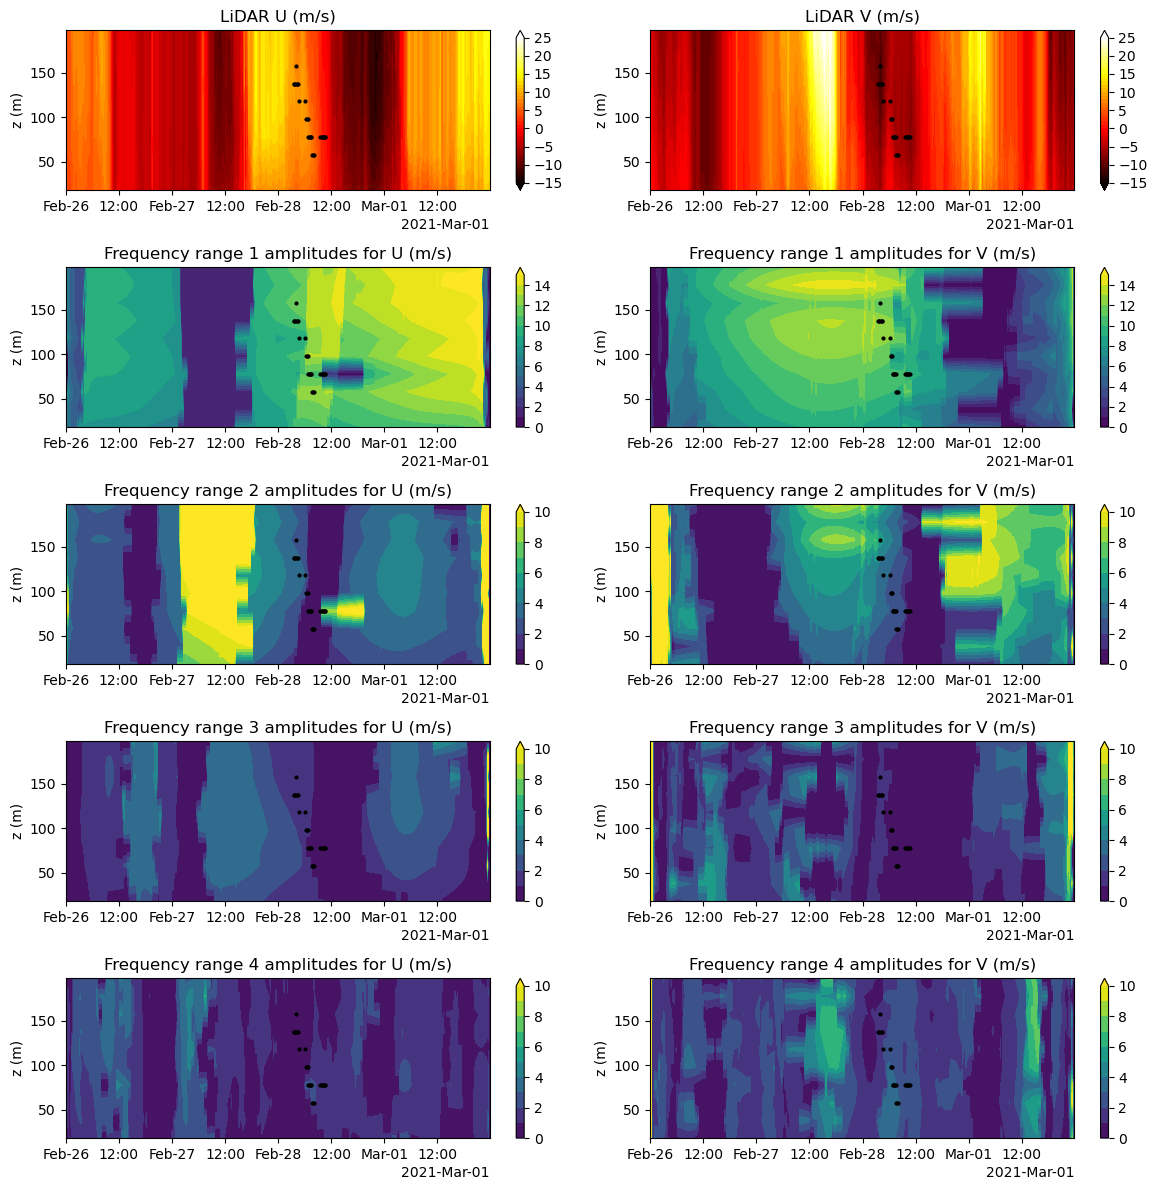

In [42]:
t_start = '2021-02-26 00:00'
t_end = '2021-03-01 23:59'

event_data = all_lidar.where(all_lidar['datetime'] < np.datetime64(t_end), drop=True)
event_data = event_data.where(event_data['datetime'] >= np.datetime64(t_start), drop=True)
jets = llj_id.sel(Time=slice(t_start, t_end))

(fig, ax) = plt.subplots(nrows=5, ncols=2, figsize=(12,12))

event = '20210228'
data = event_data
jet_data = jets

plot_data_timeheight(event, data, ax[0][0], ax[0][1], 10, jet_data, set_title='LiDAR', cmin=-15, cmax=25)

for i in range(4):
    plot_frequency_timeheight(event, data, ax[i+1][0], ax[i+1][1], 10, i, jet_data, cmax=(15 if i==0 else 10), set_title='Frequency range ' + str(i+1) + ' amplitudes for')

plt.tight_layout()

plt.savefig('frequency_timeheight_'+event+'.png')

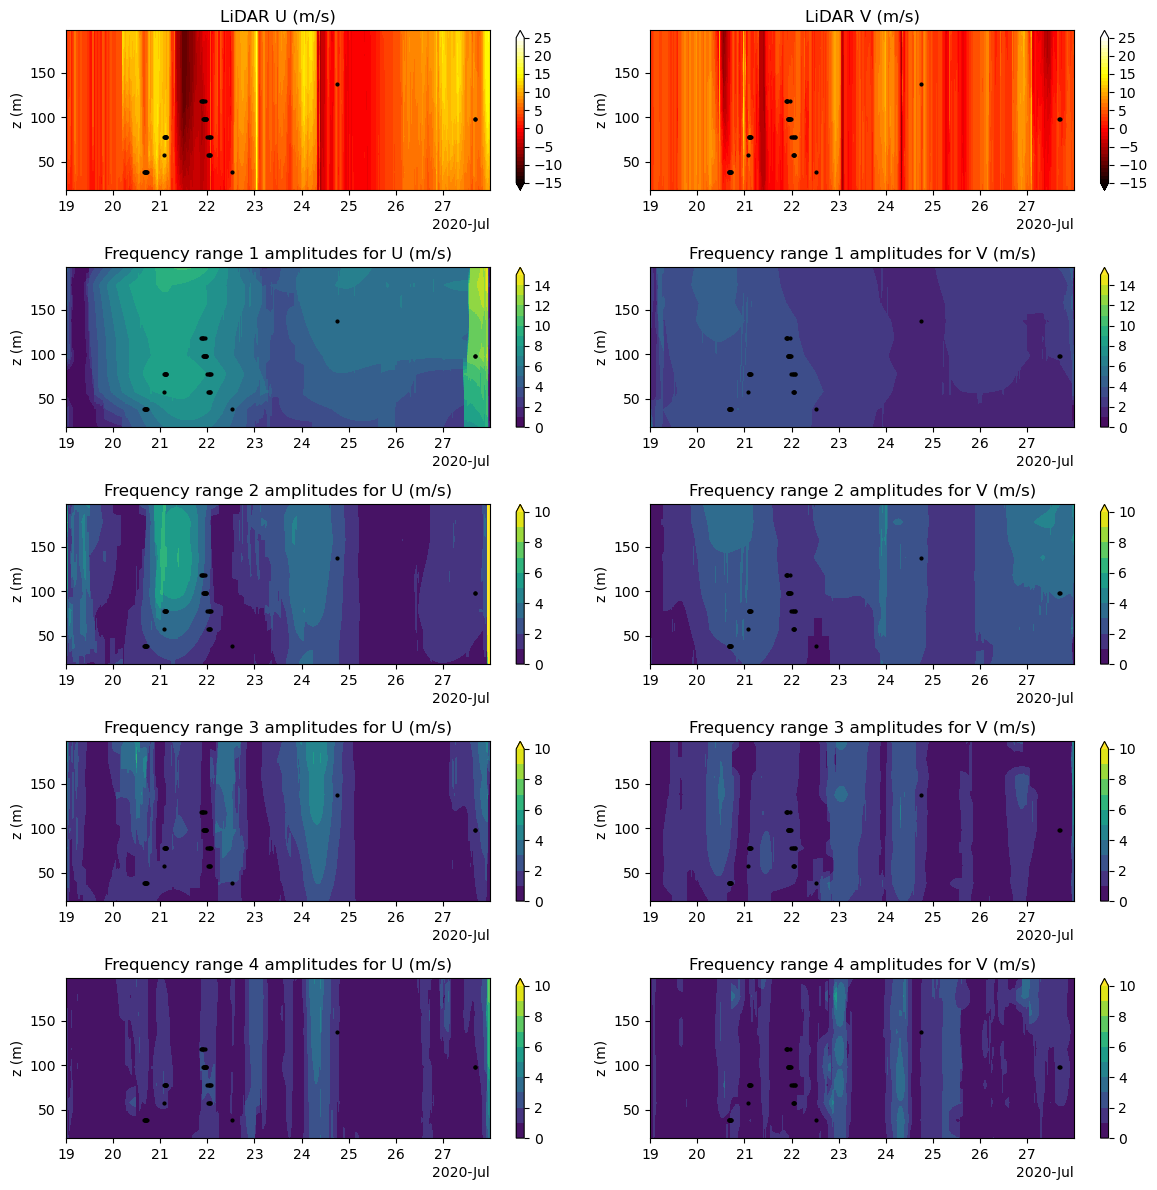

In [49]:
t_start = '2020-07-19 00:00'
t_end = '2020-07-27 23:59'

event_data = all_lidar.where(all_lidar['datetime'] < np.datetime64(t_end), drop=True)
event_data = event_data.where(event_data['datetime'] >= np.datetime64(t_start), drop=True)
jets = llj_id.sel(Time=slice(t_start, t_end))

(fig, ax) = plt.subplots(nrows=5, ncols=2, figsize=(12,12))

event = '20200720'
data = event_data
jet_data = jets

plot_data_timeheight(event, data, ax[0][0], ax[0][1], 10, jet_data, set_title='LiDAR', cmin=-15, cmax=25)

for i in range(4):
    plot_frequency_timeheight(event, data, ax[i+1][0], ax[i+1][1], 10, i, jet_data, cmax=(15 if i==0 else 10), set_title='Frequency range ' + str(i+1) + ' amplitudes for')

plt.tight_layout()

plt.savefig('frequency_timeheight_'+event+'.png')

 Inputs samples (1008) is small for specified max_imfs (9) very likely that 8 or fewer imfs are returned
 Inputs samples (1008) is small for specified max_imfs (9) very likely that 8 or fewer imfs are returned


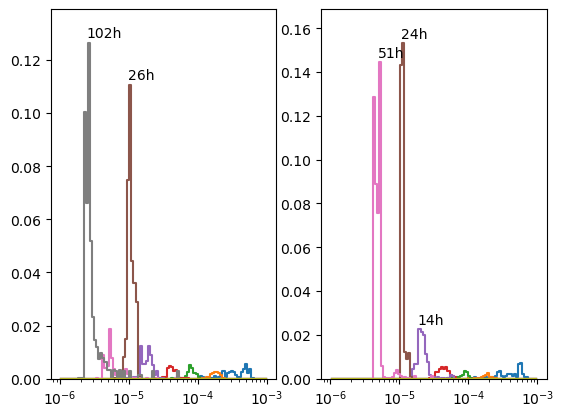

In [46]:
fig, ax = plt.subplots(ncols=2)
for (i, var) in enumerate(['U','V']):
    plot_frequency_spectra(event_data.isel(z=7), ax[i], var)